

SHNO_Memristos

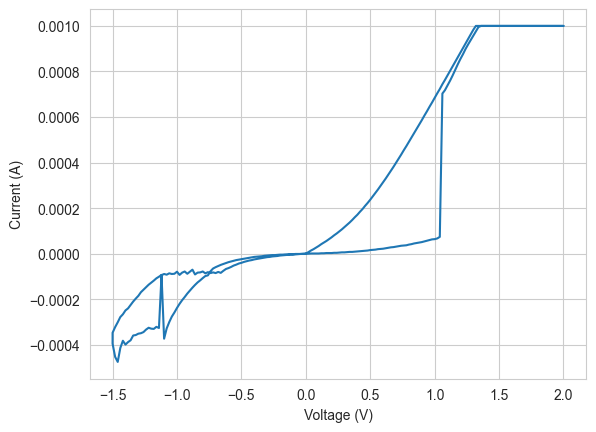

it is single field


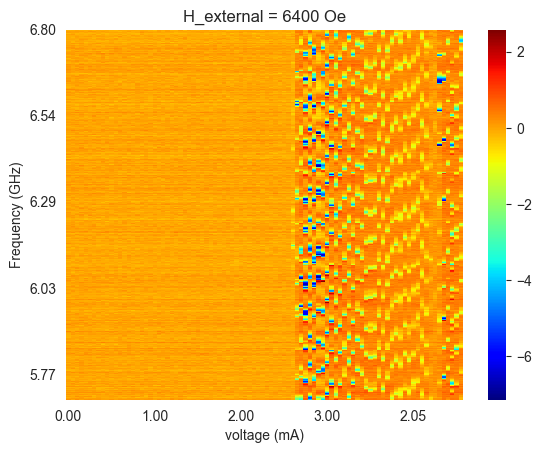

In [31]:
#************************************************************************************************************************************************************************************************************#
#**************************************************************      1st step : memristors I_V curve   ******************************************************************************************************#
#************************************************************************************************************************************************************************************************************#
import matplotlib.pyplot as plt
%matplotlib inline

mem_IV_Curve = open("/Users/.............")     #Copy and paste the .txt file name
#print(mem_IV_Curve.read())
file_lines = mem_IV_Curve.readlines()
V_G = []
I_G = []
for row in range(7,len(file_lines)):
      file_line_split= str.split(file_lines[row])
      #for column in range (len(file_line_split)):
      V_G.append(float(file_line_split[0]))
      I_G.append(float(file_line_split[1]))
plt.plot(V_G,I_G)
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.show()

#************************************************************************************************************************************************************************************************************#
#**************************************************************      2nd step : SHNO + memristors PSD   *****************************************************************************************************#
#************************************************************************************************************************************************************************************************************#

# Importing the required libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

# Defining the number of "frequencies" which is also number of "rows" in the final matrix
def numbers_of_lines():
    data = open(main_page[log_index + 1],'r')                       # For each .log file, it opens the very first .txt file after that to read the number of frequencies
    line = data.readlines()
    return(len(line)-22)

# removing the hidden files, specifically ".DS_Store" which is usually created by MacOS and add an extra file while reading the folder
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

# Defining if the log contains single or multi fields and return the corresponding value for reading .txt files
def Single_or_multi_H(lengh):
    if len(lengh) == 1:
        print('it is single field')
        return log_index + len(H_external) + 1
    else:
        print('it is multi fields')
        return (H_index_num * lengh[1])+log_index


# Giving the path of the desired folder(comprising .txt files of voltages)
#path =r"D:\.............." #Windows
path = "/Users/........."  #MacOs_Replacing your directory
main_page1= listdir_nohidden(path)

# Since it is a list,to read the file, we need to sort it as it is in the folder
os.chdir(path)
main_page = sorted(main_page1)

#Here we find the .log files
log_index = 0
log_list = []
for log_file in os.listdir(path):
    if log_file.endswith(".log"):
        log_list.append(log_file)
log_list.sort()
log_len = len(log_list)  # the number of .log files

# define voltage
#I_dc = np.zeros(len(main_page)-2)
V_G = []
H_external = []
I_G = []
txt_path = []

for log_num in range(log_len):                                      #for single/several .log file/files
    open_log = open(log_list[log_num],'r')                          #It reads each log file
    log_index = main_page.index(log_list[log_num])
    input_from_log = open_log.readlines()
    for row_in_log in range(7,len(input_from_log)):
        log_lines = input_from_log[row_in_log]
        splitted_log_lines = str.split(log_lines)
        splitted_log_lines[0] = float(splitted_log_lines[0])   #read the voltage
        splitted_log_lines[1] = float(splitted_log_lines[1])        #read the field
        splitted_log_lines[2] = float(splitted_log_lines[2])        #read the field
        V_G.append(splitted_log_lines[0])                          #Collect all voltages in I_dc
        I_G.append(splitted_log_lines[1])                          #Collect all voltages in I_dc
        H_external.append(splitted_log_lines[2])                    #Collect all fields in H_external (can be one field or several)
        txt_path.append(splitted_log_lines[3])                      #the txt_path which can be used later to address the .txt files


    V_G_unique = np.unique(V_G)                                   ###THIS PART MAYBE CAUSE PROBLEM LATER ON! if we sweep some identical voltages in a single run####
    for voltage in range(0,len(V_G)):
        V_G[voltage] = "{:.2f}".format(V_G[voltage])
    H_external_unique = np.unique(H_external,return_index=True)     #Len(H_external_Unique) is the field number
    H_external_unique_index = list(H_external_unique[1])
    H_external_unique_index.reverse()                               #the reason of reversing the list is to match with later commands
    H_external_unique_values = list(H_external_unique[0])
    H_external_unique_values.reverse()

    # Defining Lists, matrices,....
    frequency = np.zeros(numbers_of_lines())
    matrix_column = 0
    matrix_row = 0
    matrix = (numbers_of_lines(), len(V_G))                 ###THIS PART MAYBE CAUSE PROBLEM LATER ON! if we sweep some identical voltages in a single run / If so try with matrix = (numbers_of_lines(), len(V_G))   ####
    PSD_Matrix = np.zeros(matrix)


    # Reading a .txt file and put the embedded rows in a list
    H_start = log_index + 1
    for H_index_num in range(1,len(H_external_unique_index)+1):
        H_stop = Single_or_multi_H(H_external_unique_index)
        for file_number in range(H_start,H_stop):
            data = open(main_page[file_number],'r')
            line = data.readlines()
    # picking freq. and clean spectrum columns for plotting
            for row_in_file in range (21,len(line)-1):             #first 18 lines are not data
                string = line[row_in_file]
                splitted_string = str.split(string)
                for column_in_file in range(len(splitted_string)):
                    splitted_string[column_in_file] = float(splitted_string[column_in_file])   # type(Splitted_string[i]) is str.
                frequency[matrix_row] = splitted_string[0]
                PSD_Matrix[matrix_row][matrix_column] = splitted_string[2]
                matrix_row += 1

            if matrix_column < len(V_G) :                  # when one .txt file is done, it will go to the next one and add 1 to the # of column
                matrix_column += 1
                matrix_row = 0
            else:
                matrix_row = 0

        # defining frequency
        frequency = [x/1.e9 for x in frequency]
        for freq in range(0,len(frequency)):
            frequency[freq] = "{:.2f}".format(frequency[freq])

        # defining DataFrame to be able to have our own ticks and axis values
        PSD_array_indexed =pd.DataFrame(PSD_Matrix,index=frequency,columns=V_G)
        plt.title(f'H_external = {int(H_external_unique_values[H_index_num-1])} Oe')
        heatmap =sns.heatmap(PSD_array_indexed.iloc[::-1],cmap='jet')
        #heatmap.set_xticks(range(0,5,1))
        #heatmap.set_xticklabels(f'{c:.1f}' for c in np.arange(0.1, 0.6, 0.1))
        heatmap.set_xlabel('voltage (mA)')
        heatmap.set_ylabel('Frequency (GHz)')
        plt.locator_params(axis='y', nbins=5,)
        plt.locator_params(axis='x', nbins=5)
        plt.xticks(rotation = 0)
        #plt.ylim(4900,6400)
        plt.show()
        matrix_column = 0
        H_start = H_stop # It is in fact (H_index_num * H_external_unique_index[1])+ 2 + (log_index - 1) )
        #heatmap.figure.savefig('/Users/......../H_ext = '+str(int(H_external_unique_values[H_index_num-1]))+' Oe.png')

    V_G = []
    H_external = []




